# **Deep Learning Project**

## **Phase 1**



*   Sobhan Asasi    
(400206392)
*   Mohammad Hajipour   
(401301843)
*   Amin Robatian   
(400301075)




In [1]:
#!pip install face_recognition

# Requirements

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor

import face_recognition
import pickle
import cv2
import os

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import choice
import random
import time
import ast

import itertools
import re
import os
import contextlib
from typing import Any, Callable, Dict, IO, Iterable, Iterator, List, Optional, Tuple, TypeVar
import requests
from torch.utils.model_zoo import tqdm
import zipfile

import glob

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

import warnings
warnings.filterwarnings('ignore')

Using cuda device


In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Download Dataset Functions

In [4]:
def create_dataset_directory(root, dataset_name):
        
        filename_dict = {'train':'train.zip',
                         'dev':'dev.zip',
                         'test':'test.zip',
                         'MSCTD_data_train':'MSCTD_data_train.zip',
                         'MSCTD_data_dev':'MSCTD_data_dev.zip',
                         'MSCTD_data_test':'MSCTD_data_test.zip'}
        
        id_dict = {'train':'156yOz7M1sAfz4RK6OEQoPsaaPOMhrsT6',
                   'dev':'1URhTfBeUQiAmzb_2gxtn4MCXUxFywGnR',
                   'test':'1MbzM9Twe5KCWAKwZYvZO_OK-v8qRVSPF',
                   'MSCTD_data_train':'1AEwXhfMApCWzGyGr6KRzPtx7hBy3jZXt',
                   'MSCTD_data_dev': '1h3YnPZlIdSqPsggoms1zK2ZF5enSBcDH',
                   'MSCTD_data_test':'1pYWqfTd9rZuQuKgL0wv34Ybz5OINI6SV'}
        
        isExist = os.path.exists(os.path.join(root, dataset_name))
        
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(os.path.join(root, dataset_name))
            print("The " +dataset_name+ " directory is created!")
            print('Downloading ...')
            download_file_from_google_drive(id_dict['MSCTD_data_'+dataset_name],
                                            os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]))
            download_file_from_google_drive(id_dict[dataset_name],
                                os.path.join(root, dataset_name, filename_dict[dataset_name]))
            
            _extract_zip(os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]),os.path.join(root, dataset_name))
            _extract_zip(os.path.join(root, dataset_name, filename_dict[dataset_name]),os.path.join(root, dataset_name))
            
        if(dataset_name=='train'):
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0]+'_ende')]
        else:
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0])]
        
        return list_path_out


def download_file_from_google_drive(file_id: str, fpath: str):
    """Download a Google Drive file from  and place it in root.
    Args:
        file_id (str): id of file to be downloaded
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the id of the file.
    """

    url = "https://drive.google.com/uc"
    params = dict(id=file_id, export="download")
    with requests.Session() as session:
        response = session.get(url, params=params, stream=True)

        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                token = value
                break
        else:
            api_response, content = _extract_gdrive_api_response(response)
            token = "t" if api_response == "Virus scan warning" else None

        if token is not None:
            response = session.get(url, params=dict(params, confirm=token), stream=True)
            api_response, content = _extract_gdrive_api_response(response)

        if api_response == "Quota exceeded":
            raise RuntimeError(
                f"The daily quota of the file {fpath} is exceeded and it "
                f"can't be downloaded. This is a limitation of Google Drive "
                f"and can only be overcome by trying again later."
            )

        _save_response_content(content, fpath)

    # In case we deal with an unhandled GDrive API response, the file should be smaller than 10kB and contain only text
    if os.stat(fpath).st_size < 10 * 1024:
        with contextlib.suppress(UnicodeDecodeError), open(fpath) as fh:
            text = fh.read()
            # Regular expression to detect HTML. Copied from https://stackoverflow.com/a/70585604
            if re.search(r"</?\s*[a-z-][^>]*\s*>|(&(?:[\w\d]+|#\d+|#x[a-f\d]+);)", text):
                warnings.warn(
                    f"We detected some HTML elements in the downloaded file. "
                    f"This most likely means that the download triggered an unhandled API response by GDrive. "
                    f"Please report this to torchvision at https://github.com/pytorch/vision/issues including "
                    f"the response:\n\n{text}"
                )

def _extract_gdrive_api_response(response, chunk_size: int = 32 * 1024) -> Tuple[bytes, Iterator[bytes]]:
    content = response.iter_content(chunk_size)
    first_chunk = None
    # filter out keep-alive new chunks
    while not first_chunk:
        first_chunk = next(content)
    content = itertools.chain([first_chunk], content)

    try:
        match = re.search("<title>Google Drive - (?P<api_response>.+?)</title>", first_chunk.decode())
        api_response = match["api_response"] if match is not None else None
    except UnicodeDecodeError:
        api_response = None
    return api_response, content


def _save_response_content(
    content: Iterator[bytes],
    destination: str,
    length: Optional[int] = None,
) -> None:
    with open(destination, "wb") as fh, tqdm(total=length) as pbar:
        for chunk in content:
            # filter out keep-alive new chunks
            if not chunk:
                continue

            fh.write(chunk)
            pbar.update(len(chunk))


def _extract_zip(from_path: str, to_path: str) -> None:
    with zipfile.ZipFile(
        from_path, "r", compression=zipfile.ZIP_STORED
    ) as zip:
        zip.extractall(to_path)


# Extract Face

In [5]:
#!pip install facenet-pytorch

In [6]:
from facenet_pytorch import MTCNN, InceptionResnetV1
# computation device
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# create the MTCNN model, `keep_all=True` returns all the detected faces 
mtcnn = MTCNN(keep_all=True, device=device)


def extract_face(bounding_boxes, image):
    
    img_list = []
    for i in range(len(bounding_boxes)):
        x1, y1, x2, y2 = bounding_boxes[i]
        crop_img = image[int(y1):int(y2), int(x1):int(x2),:]
        
        if(crop_img.shape[0]<10 or crop_img.shape[1]<10):
            continue
        else:
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
            crop_img = cv2.resize(crop_img, dsize=(120, 160))
            tensor_crop_img = torch.tensor(crop_img.astype(int), dtype=torch.uint8).permute(2, 0, 1)
            img_list.append(tensor_crop_img) 
    
    return img_list

def face_recognize_facenet(mtcnn, img):

    img = img.permute(1, 2, 0)
    
    # create an image array copy so that we can use OpenCV functions on it
    image_array = np.array(img, dtype=np.float32)
    
    # cv2 image color conversion
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

    bounding_boxes, conf, landmarks = mtcnn.detect(img, landmarks=True)
            
    if bounding_boxes is None:
        img_list = []
    else:   
        img_list = extract_face(bounding_boxes, image_array)
    
    return img_list 
    
    

In [7]:
def files_to_dataframe(text_add, sentiment_add, index_add, img_dir):
    """
    This function convert all necessary .txt files to a single dataframe

    Args :
    text_add : .txt of chats.
    sentiment_add : .txt of emotions for each line.
    index_add : .txt of related images for each line.

    Output -> pd.dataframe

    """
    df_text = pd.read_csv(text_add, delimiter = "\r\t", header=None, engine='python')
    df_text.columns = ['text']

    df_sentiment = pd.read_csv(sentiment_add, delimiter = "\t", header=None)
    df_sentiment.columns = ['label']

    df_index = pd.read_csv(index_add, delimiter = "\t", header=None)
    df_index.columns = ['indexes']

    zero_data = np.zeros(shape=(len(df_sentiment),1),dtype=int)
    df_dialogue = pd.DataFrame(zero_data)
    df_dialogue.columns = ['dialogue']
    counter = 0
    for i in range(len(df_sentiment)):
        if i not in ast.literal_eval(df_index.indexes[counter]):
            counter += 1
        df_dialogue.dialogue[i] = counter

        
    label_list = []
    face_list = []
    face_image_index = []
    img_noface_label = []

    for idx in tqdm([*range(len(df_text))]) :

        img_path = f'{img_dir}/{idx}.jpg'
        #print(img_path)
        img = torchvision.io.read_image(path=img_path)
        face_arr = face_recognize_facenet(mtcnn, img)

        label_arr = []
        if(len(face_arr) == 0):
            face_arr.append(None)
            #label_arr.append(str(idx) + '_' + str(0))
            label_arr.append(df_sentiment.label[idx])
            img_noface_label.append(df_sentiment.label[idx])
            face_image_index.append(idx)
        else:
            for i in range(1,len(face_arr)+1):
                label_arr.append(df_sentiment.label[idx])
                face_image_index.append(idx)

        label_list.extend(label_arr)
        face_list.extend(face_arr)
        
    df_face = pd.DataFrame(face_list, columns=['face'])
    df_label_face = pd.DataFrame(label_list, columns=['label_face']) 
    df_face_image_index = pd.DataFrame(face_image_index, columns=['face_image_index'])
    
    lst = [df_text, df_sentiment, df_index, df_dialogue, df_face, df_label_face, df_face_image_index]  # List of your dataframes
    df_result = pd.concat(lst, axis =1)

    return df_result, img_noface_label
    #return text, indexes, label


# Create Dataset Class

In [8]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', img_transform=None, face_transform=None, text_transform=None, random_state=42, face_recog=False):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe, self.img_noface_label = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2], self.data_pathes[3])
        self.img_dir = self.data_pathes[3]
        self.img_transform = img_transform
        self.face_transform = face_transform
        self.text_transform = text_transform
        self.face_recog = face_recog
        
        self.counter_None = 0
        
    def __len__(self):
        
        if self.face_recog:
            len_dataset = len(self.dataframe)
        else:
            len_dataset = len(self.dataframe.label.dropna())
        
        return len_dataset
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.face_recog:
            face = self.dataframe.loc[idx, 'face']
            while face is None:
                idx += 1
                self.counter_None += 1
                face = self.dataframe.loc[idx, 'face']
            
            
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        indexes = self.dataframe.loc[idx, 'indexes']
        dialogue = self.dataframe.loc[idx, 'dialogue']
        label_face = self.dataframe.loc[idx, 'label_face']
        face_image_index = self.dataframe.loc[idx, 'face_image_index']
        
        face = self.face_transform(face)

        sample = {
            'face': face,
            'label_face': label_face,
            'face_image_index': face_image_index       
        }
        
        return sample

# Part (1) - Analysis Of Faces

## Part (1-1) - Method Implementation

In [9]:
# # Loading Datasets

face_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset_face =  MSCTDDataset(root = './data1', dataset_name = 'train', face_transform=face_transform, face_recog=True)
test_dataset_face =  MSCTDDataset(root = './data1', dataset_name = 'test', face_transform=face_transform, face_recog=True)
dev_dataset_face =  MSCTDDataset(root = './data1', dataset_name = 'dev', face_transform=face_transform, face_recog=True)

  0%|          | 0/20240 [00:00<?, ?it/s]

  0%|          | 0/5067 [00:00<?, ?it/s]

  0%|          | 0/5063 [00:00<?, ?it/s]

In [10]:
print(f'In dataset train number of all faces is {len(train_dataset_face.dataframe)} and the number of images without face is {len(train_dataset_face.img_noface_label)}')
print(f'In dataset test number of all faces is {len(test_dataset_face.dataframe)} and the number of images without face is {len(test_dataset_face.img_noface_label)}')
print(f'In dataset development number of all faces is {len(dev_dataset_face.dataframe)} and the number of images without face is {len(dev_dataset_face.img_noface_label)}')


In dataset train number of all faces is 33753 and the number of images without face is 3308
In dataset test number of all faces is 8200 and the number of images without face is 684
In dataset development number of all faces is 7869 and the number of images without face is 791


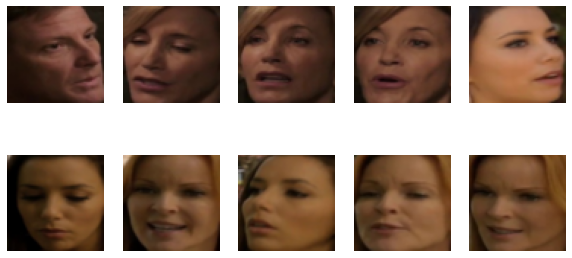

In [11]:
figure = plt.figure(figsize=(10, 5))
k = 1
for s in range(1,11):
    img = train_dataset_face[s]['face']
    figure.add_subplot(2, 5, k)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))  
    k = k +1
    
plt.show()

In [11]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset_face, 
                                            batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_face, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)

dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset_face, 
                                            batch_size=batch_size, 
                                            shuffle=True)


In [12]:
train_batch_sample = next(iter(train_loader))
print(train_batch_sample['face'].shape, train_batch_sample['label_face'].shape, train_batch_sample['face_image_index'].shape)
print(train_batch_sample)

torch.Size([64, 3, 64, 64]) torch.Size([64]) torch.Size([64])
{'face': tensor([[[[0.1255, 0.1765, 0.2745,  ..., 0.2588, 0.2118, 0.1843],
          [0.2000, 0.2784, 0.3922,  ..., 0.3490, 0.3020, 0.2706],
          [0.3137, 0.4078, 0.4980,  ..., 0.4353, 0.3882, 0.3608],
          ...,
          [0.3216, 0.3686, 0.4118,  ..., 0.3804, 0.3843, 0.3882],
          [0.3843, 0.4314, 0.4471,  ..., 0.3765, 0.3804, 0.3843],
          [0.5216, 0.5529, 0.5412,  ..., 0.3686, 0.3804, 0.3961]],

         [[0.0706, 0.1216, 0.2196,  ..., 0.1725, 0.1294, 0.1020],
          [0.1373, 0.2196, 0.3294,  ..., 0.2471, 0.1961, 0.1686],
          [0.2471, 0.3412, 0.4314,  ..., 0.3294, 0.2824, 0.2510],
          ...,
          [0.2118, 0.2549, 0.2941,  ..., 0.2627, 0.2667, 0.2706],
          [0.2588, 0.3020, 0.3216,  ..., 0.2588, 0.2627, 0.2667],
          [0.3843, 0.4196, 0.4118,  ..., 0.2510, 0.2627, 0.2784]],

         [[0.0157, 0.0549, 0.1412,  ..., 0.0941, 0.0588, 0.0431],
          [0.0745, 0.1412, 0.2314,  .

### CNN Model

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64,kernel_size = 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            
            nn.Conv2d(64, 32, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32 , 16, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
               
        )
        self.fc1 = nn.Linear(16*8*8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, inputs):
        x = self.conv(inputs)
        #print(x.shape)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return(x)

In [14]:
# creating an instance of our model

model_CNN = CNN()
model_CNN.to(device)
input_test = torch.randn((32, 3, 64, 64), device=device)
output_test = model_CNN(input_test)
print(output_test.shape)

torch.Size([32, 3])


### Loss and Optimizer

In [15]:
learning_rate = 1e-5

loss_fn = nn.CrossEntropyLoss()
sgd_opt = torch.optim.SGD(model_CNN.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 10

In [16]:
from numpy.random import choice
def predict_image_acc(face_label, face_label_pred, face_image_idx, img_noface_label):
    
    Labels = np.array([0,1,2])
    randomLabels = choice(Labels, len(img_noface_label), p=[0.34, 0.4, 0.26])                       
    correct = (np.array(img_noface_label) == randomLabels).sum()
    output, inverse_indices = torch.unique(face_image_idx, sorted=True, return_inverse=True)
#     print('My New Function')
#     print(torch.min(output), torch.max(output), output.shape, face_label.shape, face_label_pred.shape, face_image_idx.shape)
#     print(len(img_noface_label))
    
    for idx in range(output.shape[0]):
        
        true_labels = face_label[output[idx] == face_image_idx]
        pred_labels = face_label_pred[output[idx] == face_image_idx]
        if torch.bincount(true_labels).argmax() == torch.bincount(pred_labels).argmax():
            correct += 1
    return correct / (output.shape[0] + len(img_noface_label))

### Train and Test Loop

In [17]:
def train_loop(dataset, dataloader, model, loss_fn, optimizer, results, device="cpu"):
    
    label_face = torch.tensor([0])
    pred_label_face = torch.tensor([0])
    image_index = torch.tensor([0])
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, sample in enumerate(dataloader):
        
        X = sample['face'].to(device)
        y = sample['label_face'].to(device)
        label_face = torch.cat((label_face, sample['label_face']))
        image_index = torch.cat((image_index, sample['face_image_index']))
        #print(X)
        #print(next(model.parameters()).is_cuda)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        
        loss = loss_fn(pred, y)
        predict_face_label = pred.argmax(1)
        pred_label_face = torch.cat((pred_label_face, predict_face_label.to('cpu')))
        train_loss += loss.item()
        correct += (predict_face_label == y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    acc_on_imgs = predict_image_acc(label_face[1:], pred_label_face[1:], image_index[1:], dataset.img_noface_label)
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    results['train accuracy on images'].append(acc_on_imgs*100)
    print(f"Train Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    print(f'Accuracy On Images: {(100*acc_on_imgs):>0.1f}%')

def valid_loop(dataset, dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    
    label_face = torch.tensor([0])
    pred_label_face = torch.tensor([0])
    image_index = torch.tensor([0])
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            
            X = sample['face'].to(device)
            y = sample['label_face'].to(device)
            label_face = torch.cat((label_face, sample['label_face']))
            image_index = torch.cat((image_index, sample['face_image_index']))
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            predict_face_label = pred.argmax(1)
            pred_label_face = torch.cat((pred_label_face, predict_face_label.to('cpu')))
            correct += (predict_face_label == y).type(torch.float).sum().item()

    
    acc_on_imgs = predict_image_acc(label_face[1:], pred_label_face[1:], image_index[1:], dataset.img_noface_label)
    test_loss /= num_batches
    correct /= size
    results['valid accuracy on images'].append(acc_on_imgs*100)
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        print(f'Accuracy On Images: {(100*acc_on_imgs):>0.1f}%')
    else:
        print(f"Test Metrics for faces: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        print(f'Accuracy On Images: {(100*acc_on_imgs):>0.1f}%')
        

In [18]:
def train_valid(train_dataset, train_loader, valid_dataset, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      train_loop(train_dataset, train_loader, model, loss_fn, optimizer, results, device=device)
      valid_loop(valid_dataset, valid_loader, model, loss_fn, results, device=device)
    
    print("Done!")
    


In [19]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'train accuracy on images':[] , 'valid loss':[], 'valid accuracy':[], 'valid accuracy on images':[]}
train_valid(train_dataset_face, train_loader, dev_dataset_face, dev_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=model_CNN, epochs=num_epochs, device=device)

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 1.102136  [    0/33753]
Train Metrics for faces: 
 Accuracy: 34.8%, Avg loss: 1.102007
Accuracy On Images: 33.5%
Validation Metrics for faces: 
 Accuracy: 37.6%, Avg loss: 1.094376
Accuracy On Images: 35.2%
Epoch 2
-------------------------------
loss: 1.105686  [    0/33753]
Train Metrics for faces: 
 Accuracy: 34.9%, Avg loss: 1.098476
Accuracy On Images: 33.6%
Validation Metrics for faces: 
 Accuracy: 36.9%, Avg loss: 1.093595
Accuracy On Images: 34.8%
Epoch 3
-------------------------------
loss: 1.092627  [    0/33753]
Train Metrics for faces: 
 Accuracy: 34.9%, Avg loss: 1.096308
Accuracy On Images: 34.2%
Validation Metrics for faces: 
 Accuracy: 36.5%, Avg loss: 1.093468
Accuracy On Images: 34.1%
Epoch 4
-------------------------------
loss: 1.088276  [    0/33753]
Train Metrics for faces: 
 Accuracy: 35.3%, Avg loss: 1.094789
Accuracy On Images: 34.6%
Validation Metrics for faces: 
 Accuracy: 35.6

## Evaluate on Test dataset

In [20]:
valid_loop(test_dataset_face, test_loader, model_CNN, loss_fn, results, device=device, mode="test")

Test Metrics for faces: 
 Accuracy: 33.3%, Avg loss: 1.108528
Accuracy On Images: 34.9%


## Part (1-2) - Change & Increase Data

### Necessary Libraries

In [21]:
from einops import parse_shape, rearrange
import functools
import math
from opt_einsum import contract

### First Augmentation : 

In [22]:
class RandomFilter(torch.nn.Module):
    def __init__(self, kernel_size, sigma, stochastic=False, sigma_min=0.):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

        self.stochastic = stochastic
        if self.stochastic:
            self.kernels_size_candidates = torch.tensor([float(i) for i in range(self.kernel_size, self.kernel_size + 2, 2)])
            self.sigma_min = sigma_min
            self.sigma_max = sigma

    def forward(self, img):
        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        shape_dict = parse_shape(img, "b c h w")
        batch_size = shape_dict["b"]
        img = rearrange(img, "b c h w -> c b h w")

        delta = torch.zeros((1, self.kernel_size, self.kernel_size), device=img.device)
        center = int(np.ceil(self.kernel_size / 2))
        delta[0, center, center] = 1.0

        conv_weight = rearrange(
            self.sigma * torch.randn((batch_size, self.kernel_size, self.kernel_size), device=img.device) + delta,
            "b h w -> b (h w)",
        )

        conv_weight = rearrange(conv_weight, "b (h w) -> b () h w", h=self.kernel_size)

        filtered_img = torch.nn.functional.conv2d(
            img, conv_weight, padding="same", groups=batch_size
        )

        # Deal with NaN values due to mixed precision -> Convert them to 1.
        filtered_img[filtered_img.isnan()] = 1.

        filtered_img = rearrange(filtered_img, "c b h w -> b c h w")
        filtered_img = torch.clamp(filtered_img, 0., 1.).reshape(init_shape)

        return filtered_img

    def _sample_params(self):
        self.kernel_size = int(self.kernels_size_candidates[torch.multinomial(self.kernels_size_candidates, 1)].item())
        self.sigma = torch.FloatTensor([1]).uniform_(self.sigma_min, self.sigma_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f"(sigma={self.sigma}, kernel_size={self.kernel_size})"


# if __name__ == "__main__":

#     import matplotlib.pyplot as plt
#     import PIL.Image
#     import torchvision.transforms as T

#     random_filter = RandomFilter(3, 1)
#     image_path = 'kEZHm.jpg'
#     im = PIL.Image.open(image_path)
#     plt.axis("off")
#     plt.imshow(im, interpolation="nearest")
#     plt.show()

#     x = T.ToTensor()(im)
#     # x = repeat(x, 'c h w -> b c h w', b=10)
#     x2 = random_filter.forward(x)
#     plt.imshow(x.permute(1, 2, 0))
#     plt.imshow(x2.permute(1, 2, 0))
#     t = 0


### Second Augmentation :

In [23]:
class Diffeo(torch.nn.Module):
    """Randomly apply a diffeomorphism to the image(s).
    The image should be a Tensor and it is expected to have [..., n, n] shape,
    where ... means an arbitrary number of leading dimensions.
    A random cut is drawn from a discrete Beta distribution of parameters
    alpha and beta such that
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards cutmax the distribution is)
    Given cut and the allowed* interval of temperatures [Tmin, Tmax], a random T is
    drawn from a Beta distribution with parameters alpha and beta such that:
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards T_max the distribution is)
    Beta ~ delta_function for s -> inf. To apply a specific value x \in [0, 1]
    in the allowed interval of T or cut, set
        - s = 1e10
        - r = x / (1 - x)
    *the allowed T interval is defined such as:
        - Tmin corresponds to a typical displacement of 1/2 pixel in the center
          of the image
        - Tmax corresponds to the highest T for which no overhangs are present.
    Args:
        sT (float):
        rT (float):
        scut (float):
        rcut (float):
        cut_min (int):
        cut_max (int):
    Returns:
        Tensor: Diffeo version of the input image(s).
    """

    def __init__(self, sT, rT, scut, rcut, cutmin, cutmax, alpha, stochastic=False):
        super().__init__()

        self.sT = sT
        self.rT = rT
        self.scut = scut
        self.rcut = rcut
        self.cutmin = cutmin
        self.cutmax = cutmax
        self.alpha = alpha

        self.stochastic = stochastic
        if self.stochastic:
            self.cutmax_max = cutmax
            self.alpha_max = alpha

        self.betaT = torch.distributions.beta.Beta(sT - sT / (rT + 1), sT / (rT + 1), validate_args=None)
        self.betacut = torch.distributions.beta.Beta(scut - scut / (rcut + 1), scut / (rcut + 1), validate_args=None)

    def forward(self, img):
        """
        Args:
            img (Tensor): Image(s) to be 'diffeomorphed'.
        Returns:
            Tensor: Diffeo image(s).
        """

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        if self.stochastic:
            self._sample_params()

        # image size
        n = img.shape[-1]

        cut = (self.betacut.sample() * (self.cutmax + 1 - self.cutmin) + self.cutmin).int().item()
        T1, T2 = temperature_range(n, cut)
        T2 = max(T1, self.alpha * T2)
        T = (self.betaT.sample() * (T2 - T1) + T1)

        return deform(img, T, cut).reshape(init_shape)

    def _sample_params(self):
        self.cutmax = torch.randint(low=self.cutmin + 1, high=self.cutmax_max + 1, size=(1,)).item()
        # self.alpha = torch.FloatTensor([1]).uniform_(0., self.alpha_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f'(sT={self.sT}, rT={self.rT}, scut={self.scut}, rcut={self.rcut}, cutmin={self.cutmin}, cutmax={self.cutmax})'



@functools.lru_cache()
def scalar_field_modes(n, m, dtype=torch.float64, device='cpu'):
    """
    sqrt(1 / Energy per mode) and the modes
    """
    x = torch.linspace(0, 1, n, dtype=dtype, device=device)
    k = torch.arange(1, m + 1, dtype=dtype, device=device)
    i, j = torch.meshgrid(k, k)
    r = (i.pow(2) + j.pow(2)).sqrt()
    e = (r < m + 0.5) / r
    s = torch.sin(math.pi * x[:, None] * k[None, :])
    return e, s


def scalar_field(n, m, device='cpu'):
    """
    random scalar field of size nxn made of the first m modes
    """
    e, s = scalar_field_modes(n, m, dtype=torch.get_default_dtype(), device=device)
    c = torch.randn(m, m, device=device) * e
    # return torch.einsum('ij,xi,yj->yx', c, s, s)
    return contract('ij,xi,yj->yx', c, s, s)


def deform(image, T, cut, interp='linear'):
    """
    1. Sample a displacement field tau: R2 -> R2, using tempertature `T` and cutoff `cut`
    2. Apply tau to `image`
    :param img Tensor: square image(s) [..., y, x]
    :param T float: temperature
    :param cut int: high frequency cutoff
    """
    n = image.shape[-1]
    assert image.shape[-2] == n, 'Image(s) should be square.'

    device = image.device

    # Sample dx, dy
    # u, v are defined in [0, 1]^2
    # dx, dx are defined in [0, n]^2
    u = scalar_field(n, cut, device)  # [n,n]
    v = scalar_field(n, cut, device)  # [n,n]
    dx = T ** 0.5 * u * n
    dy = T ** 0.5 * v * n

    # Apply tau
    return remap(image, dx, dy, interp)


def remap(a, dx, dy, interp):
    """
    :param a: Tensor of shape [..., y, x]
    :param dx: Tensor of shape [y, x]
    :param dy: Tensor of shape [y, x]
    :param interp: interpolation method
    """
    n, m = a.shape[-2:]
    assert dx.shape == (n, m) and dy.shape == (n, m), 'Image(s) and displacement fields shapes should match.'

    y, x = torch.meshgrid(torch.arange(n, dtype=dx.dtype, device=a.device), torch.arange(m, dtype=dx.dtype, device=a.device))

    xn = (x - dx).clamp(0, m-1)
    yn = (y - dy).clamp(0, n-1)

    if interp == 'linear':
        xf = xn.floor().long()
        yf = yn.floor().long()
        xc = xn.ceil().long()
        yc = yn.ceil().long()

        xv = xn - xf
        yv = yn - yf

        return (1-yv)*(1-xv)*a[..., yf, xf] + (1-yv)*xv*a[..., yf, xc] + yv*(1-xv)*a[..., yc, xf] + yv*xv*a[..., yc, xc]

    if interp == 'gaussian':
        # can be implemented more efficiently by adding a cutoff to the Gaussian
        sigma = 0.4715

        dx = (xn[:, :, None, None] - x)
        dy = (yn[:, :, None, None] - y)

        c = (-dx**2 - dy**2).div(2 * sigma**2).exp()
        c = c / c.sum([2, 3], keepdim=True)

        return (c * a[..., None, None, :, :]).sum([-1, -2])


def temperature_range(n, cut):
    """
    Define the range of allowed temperature
    for given image size and cut.
    """
    if cut == 0:
        print("Cut is zero!")
    if isinstance(cut, (float, int)):
        cut = cut + 1e-6
        log = math.log(cut)
    else:
        log = cut.log()
    T1 = 1 / (math.pi * n ** 2 * log)
    T2 = 4 / (math.pi ** 3 * cut ** 2 * log)
    return T1, T2


def typical_displacement(T, cut, n):
    if isinstance(cut, (float, int)):
        log = math.log(cut)
    else:
        log = cut.log()
    return n * (math.pi * T * log) ** .5 / 2


# if __name__ == "__main__":

#     import matplotlib.pyplot as plt
#     import PIL.Image
#     import torchvision.transforms as T

#     random_filter = Diffeo(
#                 sT=sT, rT=rT,
#                 scut=scut, rcut=rcut,
#                 cutmin=cutmin, cutmax=cutmax,
#                 alpha=alpha, stochastic=True
#             )
#     image_path = 'kEZHm.jpg'
#     im = PIL.Image.open(image_path)
#     plt.axis("off")
#     plt.imshow(im, interpolation="nearest")
#     plt.show()

#     x = T.Resize((100,100))(im)
#     x = T.ToTensor()(x)
    
#     # x = repeat(x, 'c h w -> b c h w', b=10)
#     x2 = random_filter.forward(x)
#     plt.imshow(x.permute(1, 2, 0))
#     plt.imshow(x2.permute(1, 2, 0))
#     t = 0


### Third Augmentation : 

In [24]:
class RandomSmoothColor(torch.nn.Module):
    def __init__(self, cut, T, freq_bandwidth=None, stochastic=False, T_min=0.):
        super().__init__()
        self.cut = cut
        self.T = T
        self.freq_bandwidth = freq_bandwidth
        
        self.stochastic = stochastic
        if self.stochastic:
            self.cut_max = cut
            self.T_min = T_min
            self.T_max = T

    def forward(self, img):

        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        return self.random_smooth_color(img, self.cut, self.T, self.freq_bandwidth).reshape(init_shape)

    def _sample_params(self):
        self.cut = torch.randint(low=1, high=self.cut_max + 1, size=(1,)).item()
        self.T = torch.FloatTensor([1]).uniform_(self.T_min, self.T_max).item()

    def random_smooth_color(self, img, cut, T, freq_bandwidth=None):
        img_shape = parse_shape(img, "b c h w")
        colors = rearrange(img, "b c h w -> b c (h w)")

        if freq_bandwidth is not None:
            min_k = torch.randint(low=1, high=cut + 1, size=(1,)).item()
            k = torch.arange(
                min_k, min(min_k + freq_bandwidth, cut + 1), 
                device=img.device
            )
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], k.shape[0]), 
                device=img.device
            )
        else:
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], cut), 
                device=img.device
            )
            k = torch.arange(1, cut + 1, device=img.device)

        coeff = coeff * torch.sqrt(torch.tensor(T))

        freqs = torch.sin(colors[..., None] * k[None, None, None, :] * math.pi)

        # transformed_colors = torch.einsum("bcf,bcnf->bcn", coeff, freqs) + colors
        transformed_colors = contract("bcf, bcnf -> bcn", coeff, freqs) + colors
        transformed_colors = torch.clamp(transformed_colors, 0, 1)

        transformed_image = rearrange(transformed_colors, " b c (h w) -> b c h w", **img_shape)
        return transformed_image

    def __repr__(self):
        return self.__class__.__name__ + f"(T={self.T}, cut={self.cut})"


# if __name__ == "__main__":
#     import matplotlib.pyplot as plt
#     import PIL.Image
#     import torchvision.transforms as T

#     random_color = RandomSmoothColor(10, 0.01)

  
#     im = PIL.Image.open(image_path) ````````````````                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````  q
#     plt.axis("off")
#     plt.imshow(im, interpolation="nearest")
#     plt.show()

#     x = T.ToTensor()(im)
#     x2 = random_color(x)
#     plt.imshow(x.permute(1, 2, 0))

#     plt.imshow(x2.permute(1, 2, 0))


In [25]:
kernel_size = 8
sigma = 0.01

sT = 1.
rT = 1.
scut = 1.
rcut = 1.
cutmin = 2
cutmax = 100
alpha = 1.0

cut =  5
T = 0.01

In [26]:
random_filter = RandomFilter(kernel_size, sigma)

diffeo = Diffeo(
                sT=sT, rT=rT,
                scut=scut, rcut=rcut,
                cutmin=cutmin, cutmax=cutmax,
                alpha=alpha, stochastic=True
            )

collor_jit = RandomSmoothColor(cut, T)

## Part (1-2-1) - Create Augmented Dataset

In [27]:
class MSCTDDataset_Aug(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, dataset, dataset_name = 'train', face_transform=None, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = dataset.data_pathes
        self.dataframe, self.img_noface_label = dataset.dataframe, dataset.img_noface_label
        self.img_dir = self.data_pathes[3]
        self.face_transform = face_transform
        self.counter_None = 0
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
    
        face = self.dataframe.loc[idx, 'face']
        while face is None:
            idx += 1
            self.counter_None += 1
            face = self.dataframe.loc[idx, 'face']
            
        label_face = self.dataframe.loc[idx, 'label_face']
        face_image_index = self.dataframe.loc[idx, 'face_image_index']
        
        if self.face_transform:
            face = self.face_transform(face)
        
        if random.random() > 0.5:
            face = random_filter(face)
        
        if random.random() > 0.5:
            face = diffeo(face)
        
        if random.random() > 0.5:
            face = collor_jit(face)
            
        sample = {
                'face': face,
                'label_face': label_face,
                'face_image_index': face_image_index       
            }
            
        return sample

In [28]:
# # Loading Datasets

face_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset_aug =  MSCTDDataset_Aug(train_dataset_face, dataset_name = 'train', face_transform=face_transform)



In [29]:
train_dataset_aug[0]['face'].shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, 'Prime(Spectral + Spatial + Color)')

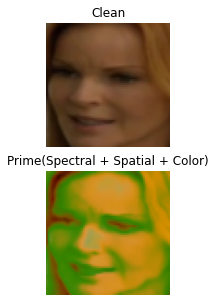

In [30]:
figure = plt.figure(figsize=(10, 5))

idx = 10

clean_img = train_dataset_face[idx]['face']
figure.add_subplot(2, 1, 1)
plt.axis("off")
plt.imshow(clean_img.permute(1, 2, 0))
plt.title('Clean')

prime_img = train_dataset_aug[idx]['face']
figure.add_subplot(2, 1, 2)
plt.axis("off")
plt.imshow(prime_img.permute(1, 2, 0))
plt.title('Prime(Spectral + Spatial + Color)')

## Concatenation Two Augmented Dataset

In [31]:
batch_size = 64



train_dataset_aug_cat = torch.utils.data.ConcatDataset([train_dataset_aug, train_dataset_aug])

print(f'Length of Augmented train dataset is {len(train_dataset_aug_cat)}')
print(f'Length of Augmented test dataset is {len(test_dataset_face)}')
print(f'Length of Augmented dev dataset is {len(dev_dataset_face)}')


train_loader_aug = torch.utils.data.DataLoader(dataset=train_dataset_aug_cat, 
                                            batch_size=batch_size, 
                                           shuffle=True)

Length of Augmented train dataset is 67506
Length of Augmented test dataset is 8202
Length of Augmented dev dataset is 7871


In [32]:
learning_rate = 1e-5

model_aug = CNN()

loss_fn = nn.CrossEntropyLoss()
sgd_opt = torch.optim.SGD(model_aug.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 10

In [33]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'train accuracy on images':[] , 'valid loss':[], 'valid accuracy':[], 'valid accuracy on images':[]}
train_valid(train_dataset_face, train_loader_aug, dev_dataset_face, dev_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=model_aug, epochs=num_epochs, device=device)

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 1.106281  [    0/67506]
loss: 1.087896  [64000/67506]
Train Metrics for faces: 
 Accuracy: 34.5%, Avg loss: 1.098165
Accuracy On Images: 34.0%
Validation Metrics for faces: 
 Accuracy: 37.2%, Avg loss: 1.093562
Accuracy On Images: 36.2%
Epoch 2
-------------------------------
loss: 1.089861  [    0/67506]
loss: 1.093375  [64000/67506]
Train Metrics for faces: 
 Accuracy: 36.0%, Avg loss: 1.094428
Accuracy On Images: 34.7%
Validation Metrics for faces: 
 Accuracy: 36.1%, Avg loss: 1.092515
Accuracy On Images: 36.0%
Epoch 3
-------------------------------
loss: 1.096627  [    0/67506]
loss: 1.081851  [64000/67506]
Train Metrics for faces: 
 Accuracy: 36.8%, Avg loss: 1.092973
Accuracy On Images: 36.2%
Validation Metrics for faces: 
 Accuracy: 35.3%, Avg loss: 1.092053
Accuracy On Images: 36.0%
Epoch 4
-------------------------------
loss: 1.107970  [    0/67506]
loss: 1.098893  [64000/67506]
Train Metrics f

In [34]:
valid_loop(test_dataset_face, test_loader, model_aug, loss_fn, results, device=device, mode="test")

Test Metrics for faces: 
 Accuracy: 39.1%, Avg loss: 1.103462
Accuracy On Images: 40.3%


## Part (1-2-2) - Augmented dataset + Original dataset  

In [14]:
# new model

class CNN_Aug(nn.Module):
    def __init__(self):
        super(CNN_Aug,self).__init__()
        
        self.conv = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64,kernel_size = 3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            
            nn.Conv2d(64, 32, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32 , 16, kernel_size = 3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
               
        )
        self.fc1 = nn.Linear(16*8*8, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv(inputs)
        #print(x.shape)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return(x)

In [36]:
# creating an instance of our model

model_Aug = CNN_Aug()
model_Aug.to(device)
input_test = torch.randn((32, 3, 64, 64), device=device)
output_test = model_Aug(input_test)
print(output_test.shape)

torch.Size([32, 3])


In [37]:
train_dataset_aug_face = torch.utils.data.ConcatDataset([train_dataset_face, train_dataset_aug_cat])

print(f'Length of (Augmented+Original) train dataset is {len(train_dataset_aug_face)}')
print(f'Length of test dataset is {len(test_dataset_face)}')
print(f'Length of dev dataset is {len(dev_dataset_face)}')


train_loader_aug_face = torch.utils.data.DataLoader(dataset=train_dataset_aug_face, 
                                            batch_size=batch_size, 
                                           shuffle=True)



Length of (Augmented+Original) train dataset is 101259
Length of test dataset is 8202
Length of dev dataset is 7871


In [38]:
learning_rate = 1e-5

model_aug_face = CNN_Aug()

loss_fn = nn.CrossEntropyLoss()
sgd_opt = torch.optim.SGD(model_aug_face.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 10

In [39]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'train accuracy on images':[] , 'valid loss':[], 'valid accuracy':[], 'valid accuracy on images':[]}
train_valid(train_dataset_face, train_loader_aug_face, dev_dataset_face, dev_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=model_aug_face, epochs=num_epochs, device=device)

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 1.096739  [    0/101259]
loss: 1.097026  [64000/101259]
Train Metrics for faces: 
 Accuracy: 35.4%, Avg loss: 1.098889
Accuracy On Images: 37.2%
Validation Metrics for faces: 
 Accuracy: 36.7%, Avg loss: 1.094144
Accuracy On Images: 36.2%
Epoch 2
-------------------------------
loss: 1.104914  [    0/101259]
loss: 1.095837  [64000/101259]
Train Metrics for faces: 
 Accuracy: 36.8%, Avg loss: 1.094215
Accuracy On Images: 38.1%
Validation Metrics for faces: 
 Accuracy: 36.5%, Avg loss: 1.092258
Accuracy On Images: 36.6%
Epoch 3
-------------------------------
loss: 1.107617  [    0/101259]
loss: 1.090251  [64000/101259]
Train Metrics for faces: 
 Accuracy: 37.1%, Avg loss: 1.092706
Accuracy On Images: 38.3%
Validation Metrics for faces: 
 Accuracy: 36.4%, Avg loss: 1.091401
Accuracy On Images: 36.3%
Epoch 4
-------------------------------
loss: 1.092389  [    0/101259]
loss: 1.086226  [64000/101259]
Train M

In [40]:
valid_loop(test_dataset_face, test_loader, model_aug_face, loss_fn, results, device=device, mode="test")

Test Metrics for faces: 
 Accuracy: 39.5%, Avg loss: 1.102688
Accuracy On Images: 40.3%


# Part (2) - Sentiment Analysis Using Whole Image Features

In [41]:
class MSCTDDatasetImage(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, dataset, dataset_name='train', img_transform=None, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = dataset.data_pathes
        self.dataframe = dataset.dataframe
        self.img_dir = dataset.img_dir
        self.img_transform = img_transform
        
    def __len__(self):
        
        return len(pd.unique(self.dataframe['face_image_index']))
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)

        if self.img_transform:
            img = self.img_transform(img)               

        sample = {
            'img': img,
            'label': self.dataframe.loc[idx, 'label'],
            'image_index': idx
        }
        
        return sample

In [42]:
# # Loading Datasets

img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



train_dataset_image =  MSCTDDatasetImage(train_dataset_face, dataset_name = 'train',img_transform=img_transform)
test_dataset_image =  MSCTDDatasetImage(test_dataset_face, dataset_name = 'test',img_transform=img_transform)
dev_dataset_image =  MSCTDDatasetImage(dev_dataset_face, dataset_name = 'dev',img_transform=img_transform)

In [43]:
print(f'The number of images in train datset is {len(train_dataset_image)}')
print(f'The number of images in test datset is {len(test_dataset_image)}')
print(f'The number of images in dev datset is {len(dev_dataset_image)}')

The number of images in train datset is 20240
The number of images in test datset is 5067
The number of images in dev datset is 5063


In [44]:
batch_size = 64

img_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_image, 
                                            batch_size=batch_size, 
                                           shuffle=True)

img_test_loader = torch.utils.data.DataLoader(dataset=test_dataset_image, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)

img_dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset_image, 
                                            batch_size=batch_size*2, 
                                            shuffle=True)


In [45]:
img_model = torchvision.models.resnet50(pretrained=True)

# Changing the requires grad of all layers to false
for param in img_model.parameters():
    param.requires_grad = False
    
# Change classifier layer
img_model.fc = nn.Sequential(
    nn.Linear(2048, 64),
    nn.ReLU(),
    nn.Linear(64,3)

)

In [46]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-4
sgd_opt = torch.optim.SGD(img_model.parameters(), lr=sgd_learning_rate, momentum=0.9)

In [47]:
def img_train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, sample in enumerate(dataloader):
        X = sample['img'].to(device)
        labels = sample['label'].type(torch.LongTensor)
        y = labels.to(device)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def img_valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            X = sample['img'].to(device)
            labels = sample['label'].type(torch.LongTensor)
            y = labels.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        

In [48]:
def img_train_valid(train_loader, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      img_train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      img_valid_loop(valid_loader, model, loss_fn, results, device=device)
    print("Done!")


In [49]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
img_train_valid(img_train_loader, img_dev_loader, loss_fn, sgd_opt, results, opt_name="SGD", model=img_model, epochs=num_epochs, device=device)

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 1.097977  [    0/20240]
Train Error: 
 Accuracy: 38.1%, Avg loss: 1.091533 

Validation Metrics: 
 Accuracy: 36.1%, Avg loss: 1.095599 

Epoch 2
-------------------------------
loss: 1.091457  [    0/20240]
Train Error: 
 Accuracy: 38.6%, Avg loss: 1.088434 

Validation Metrics: 
 Accuracy: 36.2%, Avg loss: 1.095758 

Epoch 3
-------------------------------
loss: 1.074710  [    0/20240]
Train Error: 
 Accuracy: 39.0%, Avg loss: 1.086667 

Validation Metrics: 
 Accuracy: 36.6%, Avg loss: 1.095474 

Epoch 4
-------------------------------
loss: 1.100123  [    0/20240]
Train Error: 
 Accuracy: 39.2%, Avg loss: 1.085771 

Validation Metrics: 
 Accuracy: 36.6%, Avg loss: 1.095978 

Epoch 5
-------------------------------
loss: 1.078552  [    0/20240]
Train Error: 
 Accuracy: 39.6%, Avg loss: 1.084637 

Validation Metrics: 
 Accuracy: 36.5%, Avg loss: 1.094556 

Epoch 6
-------------------------------
loss: 1.0

In [50]:
img_valid_loop(img_test_loader, img_model, loss_fn, results, device=device, mode="test")

Test Metrics: 
 Accuracy: 41.0%, Avg loss: 1.090510 



In [132]:
torch.save(img_model, 'ImageModel.pth')
torch.save(model_aug_face, 'FaceMode.pth')

In [15]:
model_aug_face = torch.load('FaceMode.pth')
img_model = torch.load('ImageModel.pth')

# Part (3) - Sentiment Analysis By Combining Two Methods

In [20]:
from random import choice
class MSCTDDataset_Mix(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, dataset, face_model, img_model, face_transform, img_transform, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = dataset.data_pathes
        self.dataframe, self.img_noface_label = dataset.dataframe, dataset.img_noface_label
        self.img_dir = self.data_pathes[3]
        self.face_transform = face_transform
        self.img_transform = img_transform
        
        #print(self.dataframe['face_image_index'])
        
        self.face_model = face_model
        self.img_model = img_model
        
        self.Labels = torch.tensor([0,1,2])
        self.weigths = [0.34, 0.4, 0.26]
        
    def __len__(self):
        
        return len(pd.unique(self.dataframe['face_image_index']))
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        
        dataframe = self.dataframe[self.dataframe['face_image_index'] == idx].reset_index(drop=True)
        num_faces = dataframe['face'].notna().sum()
        features = []
        features.append(num_faces)
        
        cls_preds = torch.zeros(len(dataframe))
        true_label = dataframe.loc[0, 'label_face']

        if num_faces > 0:
            for i in range(len(dataframe)):
                face = dataframe.loc[i, 'face']
                face = face.float()
                face = self.face_transform(face)
                face = torch.unsqueeze(face, 0)
                
                pred = self.face_model(face.to(device))
                #print(pred)
                cls_pred = pred.argmax(1)
                #print(cls_pred)
                cls_preds[i] = cls_pred
            
            # Majority Voting
            #print(cls_preds)
            face_pred = torch.bincount(cls_preds.int()).argmax()
        
        else:
            face_pred = torch.tensor(choice(self.Labels, 1, p=self.weigths))
        
        features.append(face_pred)
                
        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)
        img = img.float()
        img = self.img_transform(img)
        
        img = torch.unsqueeze(img, 0)
        pred = self.img_model(img.to(device))
        image_pred = pred.argmax(1)
        #print(pred)
        features.append(image_pred)
        
        sample = {
            'features': torch.tensor(features, dtype=torch.float),
            'label': torch.tensor(true_label, dtype=torch.float16)
        }
    
        return sample

In [21]:
face_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



dataset_mix_train = MSCTDDataset_Mix(train_dataset_face, model_aug_face, img_model, face_transform, img_transform)
dataset_mix_test = MSCTDDataset_Mix(test_dataset_face, model_aug_face, img_model, face_transform, img_transform)
dataset_mix_dev = MSCTDDataset_Mix(dev_dataset_face, model_aug_face, img_model, face_transform, img_transform)

print(f'The length of train dataset is : {len(dataset_mix_train)}')
print(f'The lenght of test dataset is : {len(dataset_mix_test)}')
print(f'The length of dev dataset is : {len(dataset_mix_dev)}')

The length of train dataset is : 20240
The lenght of test dataset is : 5067
The length of dev dataset is : 5063


In [25]:
batch_size = 64

loader_mix_train = torch.utils.data.DataLoader(dataset=dataset_mix_train, 
                                            batch_size=batch_size, 
                                           shuffle=True)

loader_mix_test = torch.utils.data.DataLoader(dataset=dataset_mix_test, 
                                            batch_size=batch_size, 
                                           shuffle=True)

loader_mix_dev = torch.utils.data.DataLoader(dataset=dataset_mix_dev, 
                                            batch_size=batch_size, 
                                           shuffle=True)

In [26]:
train_sample = next(iter(loader_mix_train))
print(train_sample['features'].shape, train_sample['label'].shape)
print(train_sample['features'].dtype, train_sample['label'].dtype)

torch.Size([64, 3]) torch.Size([64])
torch.float32 torch.float16


In [27]:
class MixModel(nn.Module):
    def __init__(self):
        super(MixModel,self).__init__()
        
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 3)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        x = self.fc1(inputs)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return(x)

model_mix = MixModel()

In [32]:
loss_fn = nn.CrossEntropyLoss()
sgd_learning_rate = 1e-5
sgd_opt = torch.optim.SGD(model_mix.parameters(), lr=sgd_learning_rate, momentum=0.9)
num_epochs = 10

In [33]:
def mix_train_loop(dataloader, model, loss_fn, optimizer, results, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for batch, sample in enumerate(dataloader):
        X = sample['features'].to(device)
        labels = sample['label'].type(torch.LongTensor)
        y = labels.to(device)
        # Compute prediction and loss
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def mix_valid_loop(dataloader, model, loss_fn, results, device="cpu", mode="valid"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for batch, sample in enumerate(dataloader):
            X = sample['features'].to(device)
            labels = sample['label'].type(torch.LongTensor)
            y = labels.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        

In [34]:
def mix_train_valid(train_loader, valid_loader, loss_fn, optimizer, results, opt_name, model, epochs, device="cpu"):
    model.to(device)
    print(f"{opt_name}\n-------------------------------")
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      #scheduler.step(t)
      mix_train_loop(train_loader, model, loss_fn, optimizer, results, device=device)
      mix_valid_loop(valid_loader, model, loss_fn, results, device=device)
    print("Done!")

In [35]:
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
mix_train_valid(loader_mix_train, loader_mix_dev, loss_fn, sgd_opt, results, opt_name="SGD", model=model_mix, epochs=num_epochs, device=device)

SGD
-------------------------------
Epoch 1
-------------------------------
loss: 1.105543  [    0/20240]
Train Error: 
 Accuracy: 38.7%, Avg loss: 1.103574 

Validation Metrics: 
 Accuracy: 36.3%, Avg loss: 1.109171 

Epoch 2
-------------------------------
loss: 1.130284  [    0/20240]
Train Error: 
 Accuracy: 38.7%, Avg loss: 1.103049 

Validation Metrics: 
 Accuracy: 36.3%, Avg loss: 1.110378 

Epoch 3
-------------------------------
loss: 1.130519  [    0/20240]
Train Error: 
 Accuracy: 38.7%, Avg loss: 1.102647 

Validation Metrics: 
 Accuracy: 36.3%, Avg loss: 1.109447 

Epoch 4
-------------------------------
loss: 1.116203  [    0/20240]
Train Error: 
 Accuracy: 38.7%, Avg loss: 1.102200 

Validation Metrics: 
 Accuracy: 36.3%, Avg loss: 1.109508 

Epoch 5
-------------------------------
loss: 1.097917  [    0/20240]
Train Error: 
 Accuracy: 38.7%, Avg loss: 1.101650 

Validation Metrics: 
 Accuracy: 36.3%, Avg loss: 1.108715 

Epoch 6
-------------------------------
loss: 1.1

## Test evaluation

In [36]:
mix_valid_loop(loader_mix_test, model_mix, loss_fn, results, device=device, mode="test")

Test Metrics: 
 Accuracy: 42.7%, Avg loss: 1.079365 



---
# Report

## Results

- Without Augmentation, we have 33.3% accuracy on faces and 34.9% on Images in Test evaluation.
- With Augmentation, we have 39.1% accuracy on faces and 40.3% on Images in Test evaluation.
- With Augmentation and faces, we have 39.5% accuracy on faces and 40.3% on Images in Test evaluation.
- Whole image(resnet50 as backbone), we have 41% on Images in Test evaluation.
- Mix of two last models, 42.7% accuracy in Test evaluation.

1 - The reults show that when we use augmentation our metrics improved and accuracy increased about 5% in test evaluation.

2 - When we used a model based on the outputs of last two models(Augment + whole image) and number of faces in each image, total accuracy increased 1% in test evaluation.

As we could predict, augmentation and mixed models helped us in prediction of sentiment by using visula information.




